## Zero-Shot Classification for Bias

In this notebook, we will use zero-shot classification with pretrained transformers to score bias of the commentators.

Zero-shot classification is a great strategy for unlabeled data.  I can use a pretrained language model such as BERT, RoBERTa, or BART to classify the games' into categories.  

There are a few well-suited pretrained transformers for my task:
- `sentence-transformers/paraphrase-mpnet-base-v2` is excellent for semantic similiarity, clustering, and ranking.
- `facebook/bart-large-mnli` is an encoder-decoder (seq2seq) model backed by Hugging Face's zero-shot pipeline.  It yields excellent results for Natural Langauge Inference (NLI) tasks using the premise-hypothesis framework. It's the most commonly used model for this type of task.
- `roberta-large-mnli` is similiar to BART but based on the RoBERTa framework.  It is slightly more complex than BART possibly giving me more accurate results than BART.  This model works well for precision-focused types of tasks.

We will use raw game transcript instead of our tokenized data.  Zero-shot classification pipeline will tokenize our text and compute embeddings on its own.  Without it, the embeddings and classification heads could mismatch leading to spurious inference results.

In [52]:
from transformers import pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch





In [53]:
# switching this between subet and full dataset
df = pd.read_json("../dataset/preprocessed_data_full.json")

In [54]:
#!pip install tf-keras
#!pip install --upgrade transformers
#!pip install torch
#!pip install  tqdm

I will analyze bias using zero-shot classification on the data.  I'll start with Meta's BART model.

In [55]:
df.head()

,game_id,teams,transcript,year,tokens,doc_embedding,broadcaster
0,1962-houston_oilers-dallas_texans.txt,"[houston_oilers, dallas_texans]",gilson well defend the goal on your left theyl...,1962,"[gilson, well, defend, the, goal, on, your, le...","[0.0272845495, 0.0167274754, 0.0260243993, 0.0...",ABC
1,1969-chicago_bears-green_bay_packers.txt,"[chicago_bears, green_bay_packers]",cbs television sports presents the national fo...,1969,"[cbs, television, sports, presents, the, natio...","[0.0302205924, 0.014963325100000001, 0.0228471...",CBS
2,1969-cleveland_browns-minnesota_vikings-1.txt,"[cleveland_browns, minnesota_vikings]",the nfl today brought to you by the foundation...,1969,"[the, nfl, today, brought, to, you, by, the, f...","[0.027876755200000002, 0.0162593126, 0.0226585...",CBS
3,1969-cleveland_browns-minnesota_vikings.txt,"[cleveland_browns, minnesota_vikings]",the nfl today brought to you by the foundation...,1969,"[the, nfl, today, brought, to, you, by, the, f...","[0.028167814000000003, 0.016339412, 0.02250985...",CBS
4,1969-new_york_jets-baltimore_colts.txt,"[new_york_jets, baltimore_colts]",&gt;&gt; nbc sports presents the third nflafl ...,1969,"[gtgt, nbc, sports, presents, the, third, nfla...","[0.0310913976, 0.0153203607, 0.024078829200000...",NBC


Run our data through the NLI RoBERTa classifier, use torch 

In [ ]:
def analyze_all_games(df):
    """ data aggregation function """
    
    # store the results in this list
    results = []
    
    # make progress bar for showing where we are at in process 
    for i, row in tqdm(df.iterrows(), total=len(df), desc="Analyzing games"):
        result = analyze_bias(row)
        if result:
            results.append(result) # breaks down the games
    
    # pd dataframe for ease of use
    results_df = pd.DataFrame(results)

In [56]:

def analyze_bias(row):
    """
    Simple function to analyze broadcast bias for a single game.
    
    Args:
        row: DataFrame row containing game information
        
    Returns:
        Dictionary with bias analysis results
    """
    try:
        # Initialize the classifier
        classifier = pipeline(
            "zero-shot-classification",
            model="cross-encoder/nli-roberta-base",
            device=0 if torch.cuda.is_available() else -1
        )
        
        # set teams
        away_team, home_team = row['teams']
        
        # Define bias labels
        labels = [
            f"shows bias towards {home_team}",
            f"shows bias towards {away_team}",
            "is neutral"
        ]
        
        #do calc here via our model
        results = classifier(row['transcript'], labels)
        
        return {
            'game_id': row['game_id'],
            'year': row['year'],
            'teams': row['teams'],
            'broadcaster': row['broadcaster'],
            'home_team': home_team,
            'away_team': away_team,
            'home_team_bias': results['scores'][0],
            'away_team_bias': results['scores'][1],
            'neutral_score': results['scores'][2],
            'predicted_bias': results['labels'][0]
        }
        
    except Exception as e:
        print(f"Error processing game {row['game_id']}: {str(e)}")
        return None



In [ ]:
def analyze_all_games(df, sample_size=None):
    """
    apply to games
    """
    # only gonna use this is want shorter results
    if sample_size:
        df = df.sample(n=sample_size, random_state=42)
    
    # Initialize results list
    results = []
    
    # Process each game with progress bar
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Analyzing games"):
        result = analyze_bias(row)
        if result:
            results.append(result)
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Create visualizations
    plt.figure(figsize=(15, 10))
    
    # 1. Average bias scores by broadcaster
    plt.subplot(2, 2, 1)
    bias_by_broadcaster = results_df.groupby('broadcaster')[['home_team_bias', 'away_team_bias', 'neutral_score']].mean()
    bias_by_broadcaster.plot(kind='bar', ax=plt.gca())
    plt.title('Average Bias Scores by Broadcaster')
    plt.xticks(rotation=45)
    plt.legend(['Home Team Bias', 'Away Team Bias', 'Neutral Score'])
    
    # 2. Bias distribution over years
    plt.subplot(2, 2, 2)
    results_df.groupby('year')['neutral_score'].mean().plot(kind='line', marker='o')
    plt.title('Neutral Score Trend Over Years')
    plt.xlabel('Year')
    plt.ylabel('Average Neutral Score')
    
    # 3. Top 10 teams with highest bias (horizontal bar chart)
    plt.subplot(2, 2, 3)
    # Combine home and away bias scores for each team
    team_bias = pd.DataFrame()
    team_bias['home_bias'] = results_df.groupby('home_team')['home_team_bias'].mean()
    team_bias['away_bias'] = results_df.groupby('away_team')['away_team_bias'].mean()
    team_bias['total_bias'] = team_bias['home_bias'] + team_bias['away_bias']
    
    # Get top 10 teams with highest total bias
    top_10_teams = team_bias['total_bias'].sort_values(ascending=False).head(10)
    top_10_teams.plot(kind='barh')
    plt.title('Top 10 Teams with Highest Total Bias')
    plt.xlabel('Total Bias Score')
    
    # 4. Box plot of bias scores
    plt.subplot(2, 2, 4)
    bias_scores = results_df[['home_team_bias', 'away_team_bias', 'neutral_score']]
    sns.boxplot(data=bias_scores)
    plt.title('Distribution of Bias Scores')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nBias Analysis Summary:")
    print(f"Total games analyzed: {len(results_df)}")
    print("\nTop 5 Teams with Highest Total Bias:")
    print(top_10_teams.head())
    
    return results_df


Analyzing games: 100%|██████████| 1216/1216 [15:11<00:00,  1.33it/s]


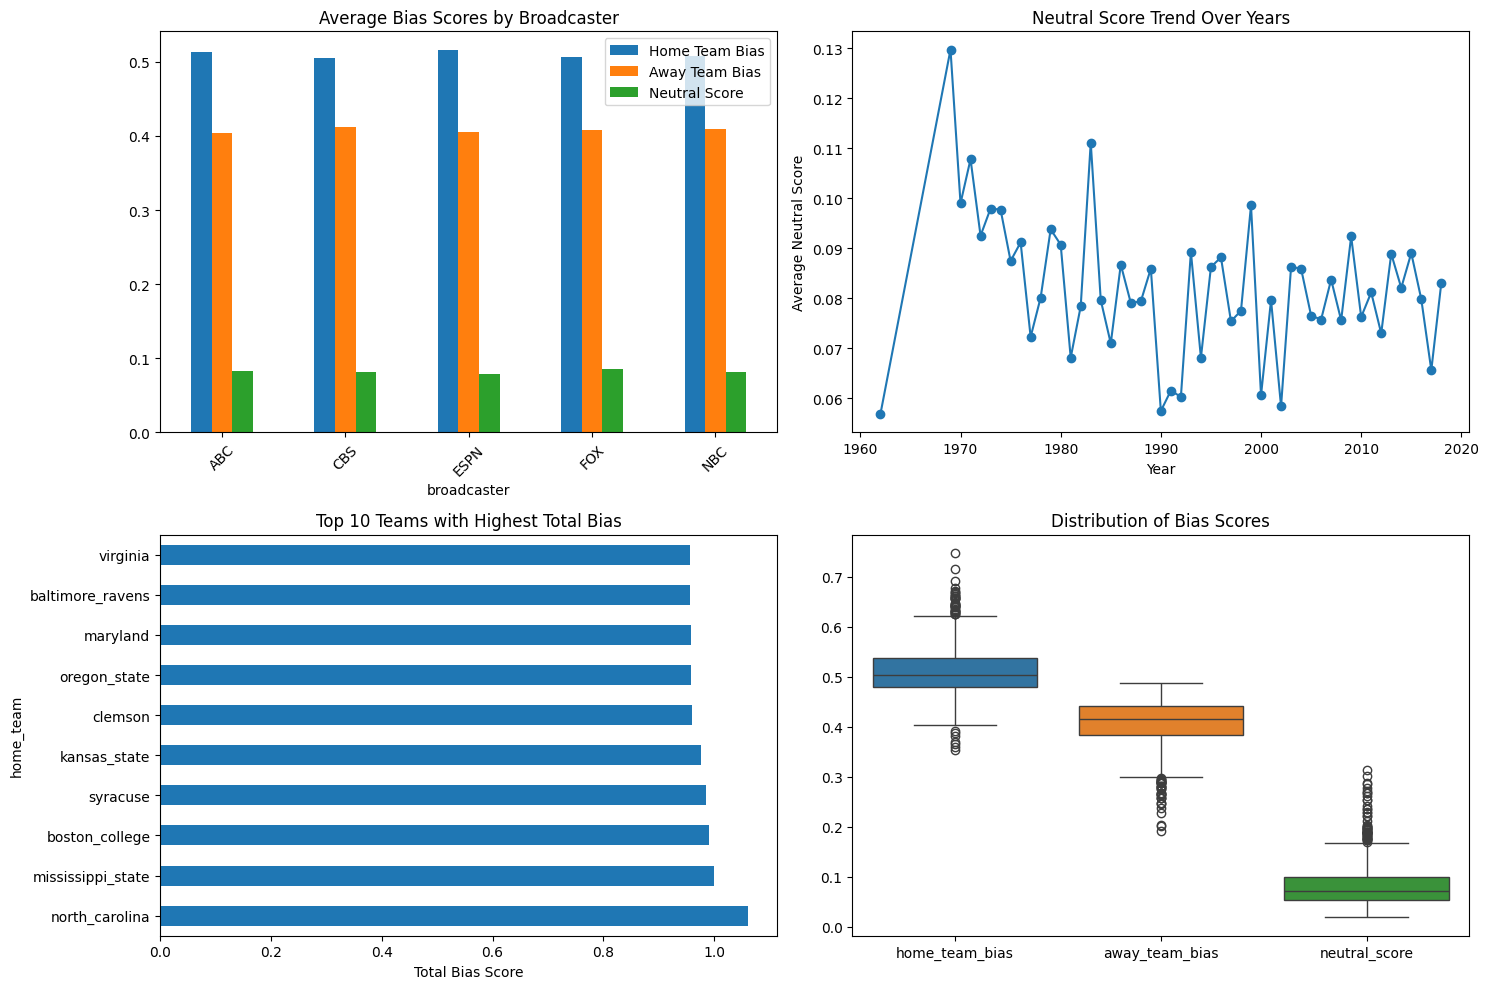


Bias Analysis Summary:
Total games analyzed: 1216

Top 5 Teams with Highest Total Bias:
home_team
north_carolina       1.060544
mississippi_state    0.999485
boston_college       0.990390
syracuse             0.985550
kansas_state         0.976240
Name: total_bias, dtype: float64


In [57]:

results_df = analyze_all_games(df)

In [60]:
# Group results by broadcaster and calculate average bias metrics
broadcaster_bias = results_df.groupby('broadcaster').agg({
    'home_team_bias': 'mean',
    'away_team_bias': 'mean',
    'neutral_score': 'mean',
    'game_id': 'count'  # Count of games per broadcaster
}).rename(columns={'game_id': 'games_analyzed'})

# Create a dictionary to store the results
broadcaster_results = {
    "overall_stats": {
        "total_games_analyzed": len(results_df),
        "average_home_bias": results_df['home_team_bias'].mean(),
        "average_away_bias": results_df['away_team_bias'].mean(),
        "average_neutral_score": results_df['neutral_score'].mean()
    },
    "broadcaster_stats": broadcaster_bias.to_dict(orient='index')
}

import json
import os

os.makedirs('notebooks/test_results', exist_ok=True)

# Save to JSON file
with open('notebooks/test_results/broadcaster_bias.json', 'w') as f:
    json.dump(broadcaster_results, f, indent=4)

print("resulted exported")


resulted exported
